**Author**: Lulof Pirée

**Date**: June 2022

--------------------------------------------------------------------------------
Copyright (C) 2022 Lulof Pirée

This file is part of the snakes_spn program.

This program is free software:
you can redistribute it and/or modify it under the terms
of the GNU General Public License as published by the Free Software Foundation,
either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY;
without even the implied warranty of MERCHANTABILITY
or FITNESS FOR A PARTICULAR PURPOSE.
See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.
If not, see <https://www.gnu.org/licenses/>.

--------------------------------------------------------------------------------
## File content
Main experiment: influence of the following variables
on the amount of inflammation-repression:
* $x_1$: Initial concentration (amount of tokens) of GbPdn.
* $x_2$: Rate constant of GbPdn cleaving ($GbPdn+Gba2 \rightarrow Pdn + Gba2$).
* $x_3$: Rate constant of Gr* unbinding ($Gr^* \rightarrow Gr + Pdn$).
* $x_4$: Rate constant of GrGbPdn unbinding ($GrGbPdn \rightarrow Gr + GbPdn$).

In [1]:
from typing import Sequence, Tuple, Any, Dict, Literal

import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.image import AxesImage
from matplotlib.colorbar import Colorbar
from matplotlib.colors import Colormap
from matplotlib import colors
from matplotlib import cm
from matplotlib.transforms import Bbox
from matplotlib.figure import Figure
import itertools
import numpy as np
import math
from scipy import stats

from spn_case_study.launch_experiment import (
    setup_init_markings_all_choices, setup_rates_all_choices)
from spn_case_study.run_grid_search import run_experiment, run_full_grid_search
from spn_case_study.petrinet import PLACES, VARS, TRANS, TRANS_TO_PLACES
from spn_tools.run_simulation import (plot_results, load_log,
    aggregate_dataset_in_timeboxes, get_num_timeboxes_for_fixed_duration)
from spn_case_study.auxiliary_tools import strip_prefix_number_from_string

## Constants

In [2]:
INIT_TOKEN_COUNT = 1000
# Amount of independent repetitions per parameter setup
NUM_REPETITIONS = 50

# Maximum of discrete transition-firings per simulation run
MAX_NUM_TRANSITIONS = 10000
# Maximum amount of simulated time passed before simulation is terminated
MAX_TIME_PASSED = 0.005

# For configuring the colour mapping of matplotlib's Axes.imshow()
VMIN = 0.45
VMAX = 1.0
NORM = colors.Normalize(VMIN, VMAX)
CMAP = "plasma_r"

# Plot formatting/typesetting
PLOT_Y_VARS = ("neutrophil_inflaming", "gr_pdn", "pdn", "infl_sig")
PLOT_Y_LIMS = (0, 1500)
PLOT_X_LIMS = (0, 0.005)
PLOT_X_LABEL = "Simulated time"
PLOT_Y_LABEL = "Token count"

## Directory structure

All files should be saved into `main_exp_data`.
This contains 4 subdirectories:
* `const_unbind_rates`: for experiments that fix $x_3 = x_4 = 0$,
    Each such subdirectory of `const_unbind_rates/x3_0__x4_0`
    contains a directory `exp_i`
    for each $i^{th}$ combination of $(x_1, x_2)$ values.
    See the `hyperparameters.json` files for the used
    values for $x_1$ and $x_2$.
* `vary_unbind_rates`: same as `const_unbind_rates`,
    but with $(x_3, x_4)$ swapped with $(x_1, x_2)$.
* `gba2_decay`: data for experiments in which Gr\* represses Gba2.
    Parameters $x_3$ and $x_4$ are fixed in all these experiments,
    but $x_1$, $x_2$ vary between the subdirectories of `gba2_decay`.
* `baseline`: for the single experiment that has $x_1=x_2=x_3=x_4=0$.
    Used an unrepressed inflammation baseline 
    to assess strength of inflammation-repression.

```
main_exp_data/

    const_unbind_rates/
        x3_CCCC__x4_DDDD/
            exp_1/
                logs.json
                hyperparameters.json
            exp_2/...
            ...../...
            exp_n/...
        .../

    vary_unbind_rates/
        x1_AAAA__x2_BBBB/
            exp_0/
                logs.json
                hyperparameters.json
            exp_1/...
            ...../...
            exp_n/...
        .../

    gba2_decay/
        x1_AAAA__x2_BBBB/
            exp_0/
                logs.json
                hyperparameters.json
            exp_1/...
            ...../...
            exp_n/...
        .../

    baseline/
        logs.json
        hyperparameters.json
```

In [3]:
MAIN_DIR_NAME = "main_exp_dir"
CONST_UNBIND_DIR_NAME = "const_unbind_rates"
VARYING_UNBIND_DIR_NAME = "vary_unbind_rates"
BASELINE_DIR_NAME = "baseline"
GBA2_DECAY_DIR_NAME = "gba2_decay"

# Notebooks usually set the cwd to the directory containing the notebook itself.
print(f"Current directory: {os.getcwd()}")
if "main_experiment.ipynb" in os.listdir(os.getcwd()):
    MAIN_SAVE_DIR = os.path.join(os.getcwd(), MAIN_DIR_NAME)
else:
    raise RuntimeError("Wrong working directory.")

CONST_UNBIND_SAVE_DIR = os.path.join(MAIN_SAVE_DIR, CONST_UNBIND_DIR_NAME)
VARYING_UNBIND_SAVE_DIR = os.path.join(MAIN_SAVE_DIR, VARYING_UNBIND_DIR_NAME)
BASELINE_SAVE_DIR = os.path.join(MAIN_DIR_NAME, BASELINE_DIR_NAME)
GBA2_DECAY_SAVE_DIR =  os.path.join(MAIN_DIR_NAME, "gba2_decay")

all_subdirs = [CONST_UNBIND_SAVE_DIR, VARYING_UNBIND_SAVE_DIR,
                BASELINE_SAVE_DIR, GBA2_DECAY_SAVE_DIR]
for dir_name in all_subdirs:
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

Current directory: /home/nifrec/Vault/Documents/master_1/bio_modelling/model_ass/snakes_spn/spn_case_study


## Baseline experiment

Data for experiment 'main_exp_dir/baseline' already exists.


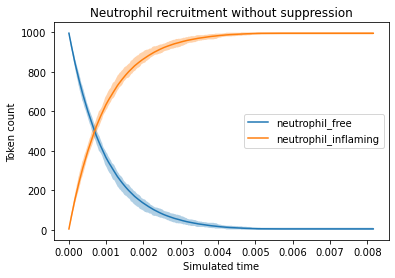

In [4]:
def check_experiment_already_done(dirname: str) -> bool:
    """
    Return whether is already a data-file of experimental data
    (a `logs.json` file) in the given directory.
    """
    dir_contents = os.listdir(dirname)
    if "logs.json" in dir_contents:
        print(f"Data for experiment '{dirname}' already exists.")
        return True
    return False

if not check_experiment_already_done(BASELINE_SAVE_DIR):
    init_markings = {name: (0,) for name in PLACES}
    init_markings["neutrophil_free"] = (INIT_TOKEN_COUNT,)
    init_markings["infl_sig"] = (INIT_TOKEN_COUNT,)

    rates = {name : "0" for name in TRANS}
    rates["recruit_neutrophil"] = f"{VARS['infl_sig']}*{VARS['neutrophil_free']}"

    run_experiment(rates, init_markings, BASELINE_SAVE_DIR, NUM_REPETITIONS, 
                        max_steps=MAX_NUM_TRANSITIONS, max_time=MAX_TIME_PASSED)


BASELINE_LOGS = load_log(os.path.join(BASELINE_SAVE_DIR, "logs.json"))
BASELINE_NUM_TIMEBOXES = 500
DESIRED_TIMEBOX_DURATION = MAX_TIME_PASSED/BASELINE_NUM_TIMEBOXES
num_timeboxes = get_num_timeboxes_for_fixed_duration(BASELINE_LOGS, 
                                        DESIRED_TIMEBOX_DURATION)
x_var = "time"
y_vars = ["neutrophil_free", "neutrophil_inflaming"]
fig, ax = plt.subplots()
ax = plot_results(BASELINE_LOGS, x_var, y_vars, 
             num_timeboxes, interval_type="min_max", ax=ax)
ax.set(ylabel=PLOT_Y_LABEL, xlabel=PLOT_X_LABEL,
    title="Neutrophil recruitment without suppression");
fig.savefig(os.path.join(MAIN_SAVE_DIR, "unrepressed_graph.pdf"))

### Comparison point
So judge the strength of inflammation-repression,
it is only fair to measure the inflammation strength
after **a fixes amount of simulated time passed**.
Fix this time to be the time after which half
the neutrophils have been recruited in the unrepressed case:

In [5]:
MAX_NEUTROPHILS_RECRUITED = INIT_TOKEN_COUNT//2
baseline_neutrophil_means, timebox_duration = \
    aggregate_dataset_in_timeboxes(BASELINE_LOGS, x_var="time",
        y_vars=["neutrophil_inflaming"], 
        num_timeboxes=BASELINE_NUM_TIMEBOXES)
baseline_neutrophil_means = \
    np.mean(baseline_neutrophil_means["neutrophil_inflaming"], axis=0)
i = 0
while baseline_neutrophil_means[i] < MAX_NEUTROPHILS_RECRUITED:
    i+=1
COMPARISON_TIMESTAMP = timebox_duration*i
print(COMPARISON_TIMESTAMP)

0.0006859455823488908


## First experiment: $x_3, x_4$ fixed

Values to try:
* $x_1 \in [10, 100, 1000, 2000, 3000] = [GbPdn]$
* $x_2 \in [0.001, 0.01, 1, 10, 100] = $ `CLEAVE_CONST`

In [6]:
# The ratio PDN_BIND_CONST-GBPDN_BIND_CONST is of interest.
# the absolute values would seem less relevant -- so fix this at 1:
PDN_BIND_CONST = 1
# It is given by the case-study provider that it is a 1000 times lower.
GBPDN_BIND_CONST = PDN_BIND_CONST/1000
# See the experiment `tune_inflam_repress_rate.ipynb`
# for the tuning of the inflammation-repression rate constant:
REPRESS_INFL_CONST = 10 
# Was fixed to this value while tuning the above:
NEUTROPHIL_RECRUIT_CONST = 1

# The variables to vary (x_1 and x_2):
GBPDN_INIT_MARKING_CHOICES = (10, 100, 1000, 2000, 3000)
CLEAVE_CONST_CHOICES = (0.001, 0.01, 1, 10, 100)

def setup_init_markings(gbpdn_init_markings: 
        Sequence[int] = GBPDN_INIT_MARKING_CHOICES) -> dict[str, Sequence[int]]:
    init_markings = {name: (0,) for name in PLACES}
    init_markings["gba2"] = (INIT_TOKEN_COUNT,)
    init_markings["gbpdn"] = gbpdn_init_markings
    init_markings["neutrophil_free"] = (INIT_TOKEN_COUNT,)
    init_markings["gr_free"] = (INIT_TOKEN_COUNT,)
    init_markings["infl_sig"] = (INIT_TOKEN_COUNT,)
    return init_markings

def setup_rates(cleave_rate_constants: Sequence[float|int]=CLEAVE_CONST_CHOICES,
                gr_pdn_decay_constants: Sequence[float|int]=(0,),
                gr_gbpdn_decay_constants: Sequence[float|int]=(0,),
                gba2_decay_constants: Sequence[float|int] = (0,),
                gba2_decay_depends_on_conc_gba2: Sequence[bool] = (True,)
                ) -> dict[str, Sequence[str]]:
    rates = {trans_name : ("0",) for trans_name in TRANS}
    rates["cleave"] = [
        f"{cleave_rate}*{VARS['gba2']}*{VARS['gbpdn']}"
        for cleave_rate in cleave_rate_constants]

    # Binding -- Mass Action
    rates["bind_pdn"] = (f"{PDN_BIND_CONST}*{VARS['pdn']}*{VARS['gr_free']}",)
    rates["bind_gbpdn"] = (f"{GBPDN_BIND_CONST}*{VARS['gbpdn']}*{VARS['gr_free']}",)

    rates["repress_infl"] = (f"{REPRESS_INFL_CONST} * "
        +f"{VARS['infl_sig']} * {VARS['gr_pdn']}",)
    rates["recruit_neutrophil"] = (f"{NEUTROPHIL_RECRUIT_CONST}*"
        + f"{VARS['neutrophil_free']}*{VARS['infl_sig']}",        
    )

    # Unbinding -- Mass Action
    rates["unbind_pdn"] = [f"{unbind_rate}*{VARS['gr_pdn']}"
        for unbind_rate in gr_pdn_decay_constants]
    rates["unbind_gbpdn"] = [f"{unbind_rate}*{VARS['gr_gbpdn']}"
        for unbind_rate in gr_gbpdn_decay_constants]

    # Gba2 decay caused by Gr* -- Mass Action
    rates["decay_gba2"] = [
        f"{rate_const}*{VARS['gr_pdn']}{gba2_conc_effect*('*' + VARS['gba2'])}"
        for rate_const in gba2_decay_constants
        for gba2_conc_effect in gba2_decay_depends_on_conc_gba2
    ]

    return rates

In [7]:
subdir_name = "x3_0__x4_0"
subdir_path = os.path.join(CONST_UNBIND_SAVE_DIR, subdir_name)
if not os.path.exists(subdir_path):
    os.mkdir(subdir_path)

if not os.path.exists(os.path.join(subdir_path, "exp_0")):
    run_full_grid_search(setup_rates(), setup_init_markings(), subdir_path, 
                        NUM_REPETITIONS, max_steps=MAX_NUM_TRANSITIONS, 
                        max_time=MAX_TIME_PASSED)

### Graph-plots as sanity check

In [8]:
num_combos = len(GBPDN_INIT_MARKING_CHOICES) * len(CLEAVE_CONST_CHOICES)

fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(10, 30))
fig.suptitle("Influence $[GbPdn]$ ($x_1$)and cleaving rate ($x_2$) "
             "on inflammation suppression",
    y=1.0, fontsize="xx-large")
axes_vector = np.reshape(axes, (-1,))



def load_log_and_hyperparams(exp_dir: str) -> Tuple[dict, dict]:
    """
    Load the logs JSON file and the hyperparameters JSON file
    stored in `exp_dir` as Python dictionaries.

    @param: exp_dir, path of directory to find JSON files in.
    @type exp_dir: str.

    @return: Tuple[dict, dict]: (logs, hyperparameters),
        "logs.json" and "hyperparameters.json" parsed
        to Python dictionaries.
    """
    logs_file =  os.path.join(exp_dir, "logs.json")
    hyperparams_file = os.path.join(exp_dir, "hyperparameters.json")
    logs = load_log(logs_file)
    hyperparams = load_log(hyperparams_file, False)
    return logs, hyperparams


for i in range(num_combos):
    exp_dir = os.path.join(CONST_UNBIND_SAVE_DIR, "x3_0__x4_0", f"exp_{i}")
    logs, hyperparams = load_log_and_hyperparams(exp_dir)

    num_timeboxes = get_num_timeboxes_for_fixed_duration(logs, 
        DESIRED_TIMEBOX_DURATION)

    gbpdn_init_markings = hyperparams["gbpdn"]
    cleaving_rate_const = strip_prefix_number_from_string(hyperparams["cleave"])

    plot_results(logs, x_var="time", 
                 y_vars = PLOT_Y_VARS,
                 num_timeboxes=num_timeboxes, 
                 ax=axes_vector[i], add_legend=False)
    axes_vector[i].set(title=f"$[GbPdn]={gbpdn_init_markings}$, "
                       +f"$x_2={cleaving_rate_const}$",
        xlim=PLOT_X_LIMS, ylim=PLOT_Y_LIMS, xlabel=None)

# Add baseline to the last axes, for comparison.
plot_results(BASELINE_LOGS, x_var="time", y_vars=PLOT_Y_VARS,
             num_timeboxes=BASELINE_NUM_TIMEBOXES, 
             ax=axes_vector[i+1])
axes_vector[i+1].set(title="Baseline $x_1=x_2=0$")
axes_vector[i+2].remove()

plt.tight_layout()
axes_vector[i+1].legend(loc=(1.25, 0.5))

# Set y-labels only on the axes of left column in the figure
for i in range(9):
    axes[i, 0].set_ylabel(PLOT_Y_LABEL)
# Set x-label only for bottom plots.
axes[8, 0].set_xlabel(PLOT_X_LABEL)
axes[8, 1].set_xlabel(PLOT_X_LABEL)

fig.savefig(os.path.join(MAIN_SAVE_DIR, "many_time_graphs.pdf"))



## Two specific subplots
The run with $x_1 = 100, x_2=10$ and the run with $x_1 = 2000, x_2 = 100$.

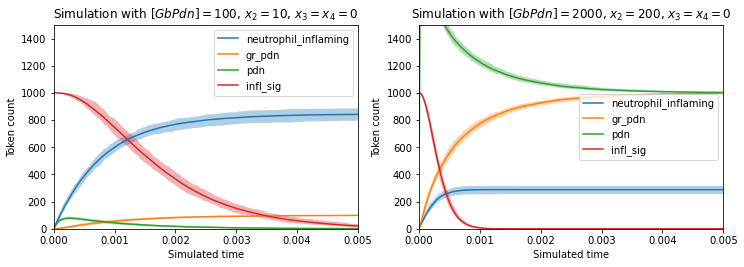

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3.75))

def plot_time_graph_default_settings(path_to_log: str, ax: Axes, title:str):
        logs = load_log(filepath=path_to_log)
        num_timeboxes = get_num_timeboxes_for_fixed_duration(logs, 
                DESIRED_TIMEBOX_DURATION)
        
        plot_results(logs, x_var = "time", y_vars = PLOT_Y_VARS, 
             ax=ax, num_timeboxes=num_timeboxes)
        ax.set(title=title,
                xlim=PLOT_X_LIMS, ylim=PLOT_Y_LIMS, 
                ylabel=PLOT_Y_LABEL, 
                xlabel=PLOT_X_LABEL);


logs_filename = os.path.join(CONST_UNBIND_SAVE_DIR, 
                             "x3_0__x4_0", "exp_16", "logs.json")
title=f"Simulation with $[GbPdn]=100$, $x_2=10$, $x_3=x_4=0$"
plot_time_graph_default_settings(logs_filename, axes[0], title)


logs_filename = os.path.join(CONST_UNBIND_SAVE_DIR, 
                             "x3_0__x4_0", "exp_23", "logs.json")
title=f"Simulation with $[GbPdn]=2000$, $x_2=200$, $x_3=x_4=0$"
plot_time_graph_default_settings(logs_filename, axes[1], title)


fig.savefig(os.path.join(MAIN_SAVE_DIR, "typical_graph.pdf"))

### Heatmap to quickly judge combinations of $x_1$ and $x_2$

Matrix where the row gives the cleave constant ($X_2$), the column
the initial amount of GbPdn ($x_1$), and the values
the observed neutrophils at `COMPARISON_TIMESTAMP`.

In [11]:
def gen_table_x1_x2_neutrophils(
    experiments_parent_dir: str, 
    x1_gbpdn_markings_choices: Sequence[int] = GBPDN_INIT_MARKING_CHOICES,
    x2_cleave_choices: Sequence[float|int] = CLEAVE_CONST_CHOICES
    ) -> np.ndarray:
    """
    Create a table that:
    * Has a column for each choice the the initial markings of GbPdn (x1).
    * Has a row for each choice of a Gba2-GbPdn-cleave-rate-constant (x2).
    * The values are the average amount of neutrophils 
        recorded after `COMPARISON_TIMESTAMP` time.
    Input must be a directory containing a subdirectory
    named 'exp_0', 'exp_1', ..., 'exp_n'
    for each of the `n+1` experiments that
    cover all possible combinations of (x1, x2) choices.

    @param experiments_parent_dir: directory containing the directories
        of individual experiments.
    @type experiments_parent_dir: str

    @param x1_gbpdn_markings_choices: all the values for the
        initial amount of tokens (x1) that were used in
        the experiments.
    @type x1_gbpdn_markings_choices: Sequence[int]

    @param x2_cleave_choices: all the values for the
        Gba2-GbPdn-cleave-rate-constant (x2) that were used in
        the experiments.
    @type x2_cleave_choices: Sequence[float | int]

    @return np.ndarray: table of floats,
        with `len(x2_cleave_choices)` rows,
        and `len(x1_gbpdn_markings_choices)` columns
        (as described above).
    """

    table = np.empty(shape=(len(x2_cleave_choices), len(x1_gbpdn_markings_choices)))

    for i in range(num_combos):
        exp_dir = os.path.join(experiments_parent_dir, f"exp_{i}")
        logs, hyperparams = load_log_and_hyperparams(exp_dir)

        num_timeboxes = get_num_timeboxes_for_fixed_duration(logs, 
            DESIRED_TIMEBOX_DURATION)

        agg_logs, timebox_duration = aggregate_dataset_in_timeboxes(
            logs, x_var="time",
            y_vars=["neutrophil_inflaming", "gr_pdn", "pdn"], 
            num_timeboxes=num_timeboxes)

        time_vect = [timebox_duration*t for t in range(num_timeboxes)]
        timebox_idx = 0
        while time_vect[timebox_idx] < COMPARISON_TIMESTAMP:
            timebox_idx += 1

        gbpdn_init_markings = hyperparams["gbpdn"]
        cleaving_rate_const = strip_prefix_number_from_string(hyperparams["cleave"])

        row_idx = x2_cleave_choices.index(eval(cleaving_rate_const))
        col_idx = x1_gbpdn_markings_choices.index(gbpdn_init_markings)

        neutrophils_at_comparison_time = np.mean(
            [run_vector[timebox_idx] 
            for run_vector in agg_logs["neutrophil_inflaming"]])

        table[row_idx, col_idx] = neutrophils_at_comparison_time
    return table

experiments_parent_dir = os.path.join(CONST_UNBIND_SAVE_DIR, "x3_0__x4_0")
table = gen_table_x1_x2_neutrophils(experiments_parent_dir)
print(table)


[[501.35       500.77       500.96733333 502.2075     497.52225397]
 [500.98       500.483      501.05283333 501.43246032 499.96238817]
 [504.01147619 497.42383333 465.18254928 444.3240052  420.74628535]
 [499.267      487.35282506 388.06563625 329.50600578 296.86166255]
 [498.71811905 477.91807521 358.18601909 282.41058009 246.57404762]]


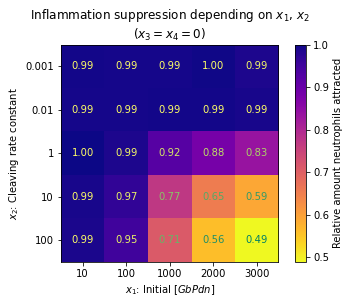

In [12]:
def make_heatmap(table: np.ndarray, 
                 col_labels: Sequence[str], 
                 row_labels:Sequence[str],
                 ax:Axes=None,
                 cmap: str | Colormap="plasma_r",
                 imshow_kwargs: Dict[str, Any] = {},
                 add_colorbar: bool=True
                 ) -> Tuple[Axes, AxesImage, Colorbar|None] :
    if ax is None:
        _, ax = plt.subplots()
    
    num_rows, num_cols = table.shape

    ax.set_yticks(np.arange(num_rows))
    ax.set_yticklabels(row_labels)
    ax.set_xticks(np.arange(num_cols))
    ax.set_xticklabels(col_labels)

    image = ax.imshow(table, cmap=cmap, **imshow_kwargs)

    if add_colorbar:
        colorbar = ax.figure.colorbar(image, ax=ax)
    else:
        colorbar = None

    min_val = np.min(table)
    max_val = np.max(table)
    num_values = table.size
    text_colors = cm.summer(np.linspace(0, 1, num_values))


    for row in range(num_rows):
        for col in range(num_cols):
            tab_value = table[row, col]
            label=f"{tab_value:.2f}"
            colour_idx = round(((tab_value - min_val)/(max_val-min_val)) * (num_values-1))
            ax.text(col, row, label, ha="center", va="center",
                color=text_colors[colour_idx])

    return ax, image, colorbar

fig, ax = plt.subplots()
ax, image, colorbar = make_heatmap(table/np.max(table), 
                    GBPDN_INIT_MARKING_CHOICES, CLEAVE_CONST_CHOICES,
                    ax=ax)
ax.set_xlabel("$x_1$: Initial $[GbPdn]$")
ax.set_ylabel("$x_2$: Cleaving rate constant")
ax.set_title("Inflammation suppression depending on $x_1$, $x_2$\n($x_3=x_4=0$)")
colorbar.ax.set_ylabel("Relative amount neutrophils attracted");
fig.savefig(os.path.join(MAIN_SAVE_DIR, "no_unbind_heatmap.pdf"))

# Big experiment: $x_3$ and $x_4$ vary
Repeat the above experiment, but now for different values of
$x_3$ and $x_4$. For each combination of $(x_3, x_4)$,
make a heatmap with all combinations of $(x_1, x_2)$.
Then combine these heat-maps in a bigger table.

Note that this is basically finding way to represent 4-dimensional data.
It would unfortunately not be possible to visualize a 4D heatmap.

In [13]:

GRPDN_UNBIND_CONST_CHOICES = (0, 1000, 3000)
GRGBPDN_UNBIND_CONST_CHOICES = (0, 1000, 3000)

def x3_x4_combo_to_subdir_name(x3: float|int, x4: float|int) -> str:
    """
    Standardized way of mapping a combination between
    variables x3 and x4 to a name for the parent directory
    of all the experiment-directories.

    @param x3: Gr-Pdn unbind-rate-constant.
    @type x3: float|int

    @param x4: Gr-Pdn unbind-rate-constant.
    @type x4: float|int

    @return str: name for the directory.

    >>> x3_x4_combo_to_subdir_name(0.001, 100)
    "x3_1e-20__x4_1e+02"
    """
    return f"x3_{x3:.0e}__x4_{x4:.0e}"

def run_nested_grid_search(
    top_level_save_dir: str = VARYING_UNBIND_SAVE_DIR,
    x1_gbpdn_markings_choices: Sequence[int] = GBPDN_INIT_MARKING_CHOICES,
    x2_cleave_choices: Sequence[float|int] = CLEAVE_CONST_CHOICES,
    x3_grpdn_unbind_choices: Sequence[float|int] = GRPDN_UNBIND_CONST_CHOICES,
    x4_grgbpdn_unbind_choices: Sequence[float|int] = GRGBPDN_UNBIND_CONST_CHOICES
    ):

    all_x3_x4_combos = itertools.product(x3_grpdn_unbind_choices, 
                                         x4_grgbpdn_unbind_choices)
    for (x3_rate, x4_rate) in all_x3_x4_combos:
        print(f"Next (x3, x4) combination:{(x3_rate, x4_rate)}.")

        subdir_name = x3_x4_combo_to_subdir_name(x3_rate, x4_rate)
        subdir_path = os.path.join(top_level_save_dir, subdir_name)
        if not os.path.exists(subdir_path):
            os.mkdir(subdir_path)
        elif "exp_0" in os.listdir(subdir_path):
            print(f"Already data found for (x3, x4) "
            f"combination:{(x3_rate, x4_rate)}.\n"
            "Skipping this entire combination (skipping all x1, x2 combos).")
            continue
        print(f"Saving to path: {subdir_path}")

        all_rates_choices = setup_rates(
            cleave_rate_constants=x2_cleave_choices,
            gr_pdn_decay_constants=(x3_rate,),
            gr_gbpdn_decay_constants=(x4_rate,))

        all_markings_choices = setup_init_markings(x1_gbpdn_markings_choices)

        
        
        if not os.path.exists(os.path.join(subdir_path, "exp_0")):
            run_full_grid_search(rates_all_choices=all_rates_choices, 
                                init_markings_all_choices=all_markings_choices, 
                                top_level_save_dir=subdir_path,
                                num_repetitions=NUM_REPETITIONS, 
                                max_steps=MAX_NUM_TRANSITIONS, 
                                max_time=MAX_TIME_PASSED)

In [14]:
run_nested_grid_search(VARYING_UNBIND_SAVE_DIR)

Next (x3, x4) combination:(0, 0).
Already data found for (x3, x4) combination:(0, 0).
Skipping this entire combination (skipping all x1, x2 combos).
Next (x3, x4) combination:(0, 1000).
Already data found for (x3, x4) combination:(0, 1000).
Skipping this entire combination (skipping all x1, x2 combos).
Next (x3, x4) combination:(0, 3000).
Already data found for (x3, x4) combination:(0, 3000).
Skipping this entire combination (skipping all x1, x2 combos).
Next (x3, x4) combination:(1000, 0).
Already data found for (x3, x4) combination:(1000, 0).
Skipping this entire combination (skipping all x1, x2 combos).
Next (x3, x4) combination:(1000, 1000).
Already data found for (x3, x4) combination:(1000, 1000).
Skipping this entire combination (skipping all x1, x2 combos).
Next (x3, x4) combination:(1000, 3000).
Already data found for (x3, x4) combination:(1000, 3000).
Skipping this entire combination (skipping all x1, x2 combos).
Next (x3, x4) combination:(3000, 0).
Already data found for (x3,

## Table of heatmaps

In [15]:
def make_table_of_heatmaps(
    top_level_save_dir: str = VARYING_UNBIND_SAVE_DIR,
    x1_gbpdn_markings_choices: Sequence[int] = GBPDN_INIT_MARKING_CHOICES,
    x2_cleave_choices: Sequence[float|int] = CLEAVE_CONST_CHOICES,
    x3_grpdn_unbind_choices: Sequence[float|int] = GRPDN_UNBIND_CONST_CHOICES,
    x4_grgbpdn_unbind_choices: Sequence[float|int] = GRGBPDN_UNBIND_CONST_CHOICES
    ) -> Tuple[Figure, Axes]:

    mpl.rc("axes", labelsize=15)

    num_cols = len(x3_grpdn_unbind_choices)
    num_rows = len(x4_grgbpdn_unbind_choices)

    axes = [[None for col in range(num_cols)] for row in range(num_rows)]
    images = [[None for col in range(num_cols)] for row in range(num_rows)]

    fig, superax = plt.subplots(figsize=(13, 13))
    superax.set_title("Neutrophils recruited depending on $x_1, x_2, x_3, x_4$",
        fontsize=16)
    superax.set_xlabel("$x_3$: Gr-Pdn unbind rate constant")
    superax.set_ylabel("$x_4$: Gr-GbPdn unbind rate constant")
    superax_xlim = [0.2, num_cols+0.5]
    superax.set_xlim(superax_xlim)
    superax_ylim = [0.2, num_rows+0.5]
    superax.set_ylim(superax_ylim)
    superax.set_xticks([x for x in range(1, num_cols+1)])
    superax.set_yticks([y for y in range(1, num_rows+1)])
    superax.set_xticklabels(x3_grpdn_unbind_choices)
    superax.set_yticklabels(x4_grgbpdn_unbind_choices)

    superax.text(np.mean(superax_xlim), 0.4, 
        "$x_1$: Initial $[GbPdn]$", ha="center", va="center",
                color="black",
                in_layout=False,
                fontsize=13)

    superax.text(0.4, np.mean(superax_ylim),
        "$x_2$: Cleaving rate constant", ha="center", va="center",
                color="black",
                in_layout=False,
                rotation="vertical",
                fontsize=13)

    fig.execute_constrained_layout()
    value_to_color_mapping = cm.ScalarMappable(NORM, cmap=CMAP)
    colorbar = superax.figure.colorbar(value_to_color_mapping, 
                                        shrink=0.3,
                                        aspect=15,
                                        pad=0.01)#, ax=superax)
    colorbar.ax.set_ylabel("Relative amount neutrophils recruited")
    
    for level_1_dir in os.listdir(top_level_save_dir):
        try:
            dir_full_path = os.path.join(top_level_save_dir, level_1_dir)
            hyperparams = load_log(
                os.path.join(dir_full_path, "exp_0", "hyperparameters.json"), 
                convert_int_keys=False)
            x3 = eval(strip_prefix_number_from_string(hyperparams["unbind_pdn"]))
            col = x3_grpdn_unbind_choices.index(x3)
            x4 = eval(strip_prefix_number_from_string(hyperparams["unbind_gbpdn"]))
            row = x4_grgbpdn_unbind_choices.index(x4)
            table = gen_table_x1_x2_neutrophils(dir_full_path)
            table = table / MAX_NEUTROPHILS_RECRUITED

            bb_data_ax = Bbox.from_bounds(col+0.60,row+0.60, 0.8, 0.8)
            disp_coords = superax.transData.transform(bb_data_ax)
            fig_coords_ax = fig.transFigure.inverted().transform(disp_coords)
            bb_ax = Bbox(fig_coords_ax)
            ax = fig.add_axes(bb_ax)

            ax, img, _ = make_heatmap(table, 
                col_labels=x1_gbpdn_markings_choices,
                row_labels=x2_cleave_choices,
                ax=ax,
                add_colorbar=False,
                cmap=CMAP,
                imshow_kwargs = {
                    "vmin":VMIN,
                    "vmax":VMAX})

            axes[row][col] = ax
            images[row][col] = img
        except ValueError as e:
            print(f"Some file could not be loaded: {level_1_dir}.\n", e)
    
    mpl.rcdefaults()

    return (fig, superax)

Some file could not be loaded: x3_0e+00__x4_1e+00.
 tuple.index(x): x not in tuple
Some file could not be loaded: x3_1e+00__x4_0e+00.
 tuple.index(x): x not in tuple
Some file could not be loaded: x3_1e+00__x4_1e+00.
 tuple.index(x): x not in tuple
Some file could not be loaded: x3_1e+00__x4_1e+03.
 tuple.index(x): x not in tuple
Some file could not be loaded: x3_1e+00__x4_3e+03.
 tuple.index(x): x not in tuple
Some file could not be loaded: x3_1e+03__x4_1e+00.
 tuple.index(x): x not in tuple
Some file could not be loaded: x3_3e+03__x4_1e+00.
 tuple.index(x): x not in tuple


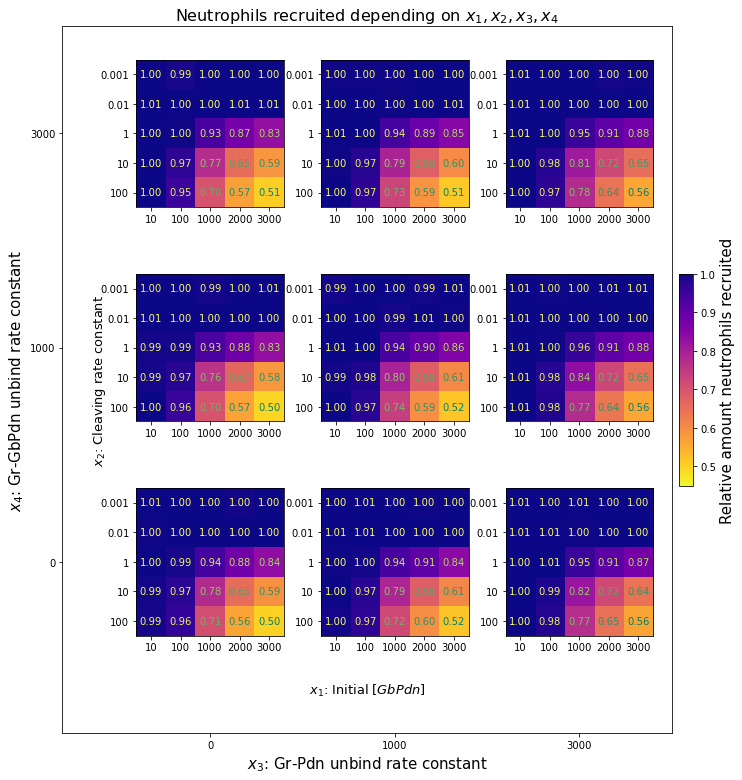

In [16]:
fig, superax = make_table_of_heatmaps()

In [17]:
fig.savefig(os.path.join(MAIN_SAVE_DIR, "table_of_heatmaps.pdf"))

## Individual runs as sanity check

The unbind rates of Pdn and GbPdn do have effect
on the amount of Gr*, but the repression
of inflammation signals is still strong enough
that it does not matter much for the amount of neutrophils attracted.

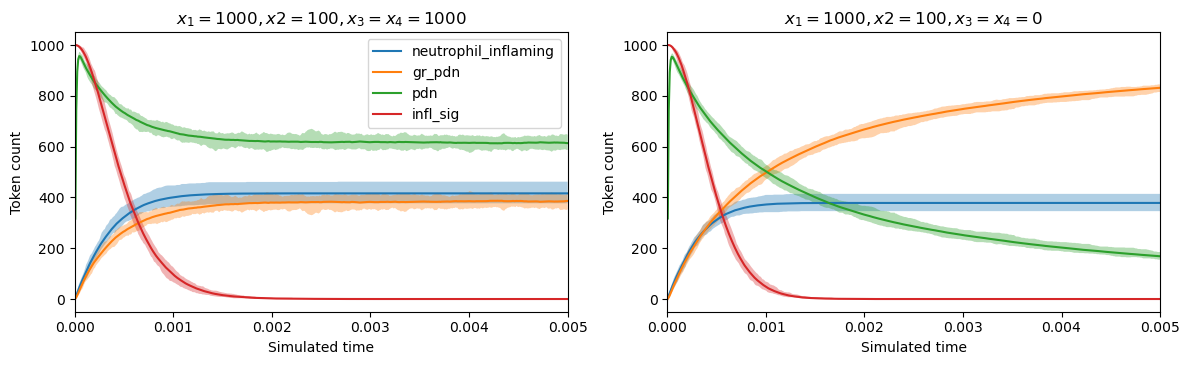

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3.75))

logs_fast_unbind = load_log(os.path.join(VARYING_UNBIND_SAVE_DIR,
                             "x3_1e+03__x4_1e+03",
                             "exp_22",
                             "logs.json"))
num_timeboxes = get_num_timeboxes_for_fixed_duration(logs_fast_unbind, 
                                        DESIRED_TIMEBOX_DURATION)
x_var = "time"
y_vars = ["neutrophil_inflaming", "gr_pdn", "pdn", "infl_sig"]
ax = axes[0]
ax = plot_results(logs_fast_unbind, x_var, y_vars, 
             num_timeboxes, interval_type="min_max", ax=ax)
ax.set(ylabel=PLOT_Y_LABEL, xlabel=PLOT_X_LABEL, xlim=PLOT_X_LIMS,
    title="$x_1=1000, x2=100, x_3=x_4=1000$")


logs_no_unbind = load_log(os.path.join(VARYING_UNBIND_SAVE_DIR,
                             "x3_1e+00__x4_1e+00",
                             "exp_22",
                             "logs.json"))
num_timeboxes = get_num_timeboxes_for_fixed_duration(logs_no_unbind, 
                                        DESIRED_TIMEBOX_DURATION)
ax=axes[1]
ax = plot_results(logs_no_unbind, x_var, y_vars, 
             num_timeboxes, interval_type="min_max", ax=ax, add_legend=False)
ax.set(ylabel=PLOT_Y_LABEL, xlabel=PLOT_X_LABEL, xlim=PLOT_X_LIMS,
    title="$x_1=1000, x2=100, x_3=x_4=0$")

fig.tight_layout()
fig.savefig(os.path.join(MAIN_SAVE_DIR, 
                         "effect_unbind__rates_graphs.pdf"))

## Test of significance effect $x_3$

The table-of-heatmaps shows
a 6% increase in neutrophils attracted 
between the runs $(x_1=3000, x_2=100, x_3=3000, x_4=0)$
and $(x_1=3000, x_2=100, x_3=0, x_4=0)$.
Although small, it is of theoretical importance.
So it seems important to ensure this effect is not due to chance!

In [19]:
def test_runs_different(run_1_logs_file:str, 
                        run_2_logs_file:str,
                        alt: Literal["two-sided", "less", "greater"]):
    """
    Given two sets of experiment outputs,
    determine with Student's t-test whether
    the average amount of neutrophils at COMPARISON_TIMESTAMP
    are significantly different.
    Print the results of the test.
    
    Arguments:
    * run_1_logs_file, run_2_logs_file: paths including filename
        for the JSON logs of the two experiments to compare.
    * alt: alternative hypothesis for the relation between
        the first and the second dataset.
    """
    observations_1 = _get_observations(run_1_logs_file)
    observations_2 = _get_observations(run_2_logs_file)
    t, p = stats.ttest_ind(observations_1, observations_2, alternative=alt)
    print(f"Prob H0 (equal means): {p}.")
    
def _get_observations(logs_filename) -> Sequence[float]:
    logs = load_log(logs_filename)

    num_timeboxes_1 = get_num_timeboxes_for_fixed_duration(logs, 
                                        DESIRED_TIMEBOX_DURATION)
    agg_data, timebox_duration = aggregate_dataset_in_timeboxes(
        logs, "time", ("neutrophil_inflaming",), num_timeboxes_1
    )
    timebox_idx = math.floor(COMPARISON_TIMESTAMP/timebox_duration)
    observations = [run_vector[timebox_idx]
        for run_vector in agg_data["neutrophil_inflaming"]]
    return observations

run_1_logs_file = os.path.join(VARYING_UNBIND_SAVE_DIR,
    "x3_0e+00__x4_0e+00", "exp_24", "logs.json")
run_2_logs_file = os.path.join(VARYING_UNBIND_SAVE_DIR,
    "x3_3e+03__x4_0e+00", "exp_24", "logs.json")
alternative="less"
test_runs_different(run_1_logs_file, run_2_logs_file, alternative)


Prob H0 (equal means): 1.0307028879249196e-17.


# Third experiment: Gba2 decays due to Gr*

The above experiments used a constant amount of Gba2.
However, biologically it seems that Gba2 is only
produced in inflaming cells, and Gr* stops
the inflammation.
So perhaps Gr* can block itself by stopping the Gba2 production
too early (needed to produce Pdn from GbPdn,
and Pdn is needed to create Gr*).

We take the values of $x_1, x_2, x_3, x_4$
at which strong inflammation repression
occurs under constant Gba2 
(if we would consider a case in which
the inflammation was not repressed,
then no observable effect of Gba2-decay is possible.
I.e., the decay of Gba2 cannot mess something
up that is already ruined).

In particular:
* $x_1 = 3000$
* $x_2 = 100$
* $x_3 = 0$
* $x_4 = 0$

Two other variables instead are varied:
* $x_5$: the decay-rate-constant in the Gba2-decay rate formula.
* $x_6$: the choice whether to let the decay of Gba2 be proportional
    to the current concentration $[Gba2]$.

Hence the rate-formula for the transition
$Gba2 + Gr^* \rightarrow Gr^*$
(this is not a physical reaction, of course, Gr* does regulates
Gba2 indirectly)
is
$\lambda = x_5 \cdot [Gr^*] \cdot \begin{cases}[Gba2]& x_6=
\texttt{True}\\1&x_6=\texttt{False}\end{cases}$

In [44]:
GBA2_DECAY_INIT_GBPDN = 3000
GBA2_DECAY_CLEAVE_RATE_CONST = 100

GBA2_DECAY_RATE_CONSTANTS = (0, 1, 10, 100, 1000, 100000)
GBA2_DECAY_RATE_PROP_TO_GBA2 = (True, False)

def setup_gba2_decay_markings() -> Dict[str, Sequence[int]]:
    init_markings = {name: (0,) for name in PLACES}
    init_markings["gba2"] = (INIT_TOKEN_COUNT,)
    init_markings["gbpdn"] = (GBA2_DECAY_INIT_GBPDN, )
    init_markings["neutrophil_free"] = (INIT_TOKEN_COUNT,)
    init_markings["gr_free"] = (INIT_TOKEN_COUNT,)
    init_markings["infl_sig"] = (INIT_TOKEN_COUNT,)
    return init_markings

rates_all_choices = setup_rates(
    cleave_rate_constants = (GBA2_DECAY_CLEAVE_RATE_CONST,),
    gba2_decay_constants = GBA2_DECAY_RATE_CONSTANTS,
    gba2_decay_depends_on_conc_gba2 = GBA2_DECAY_RATE_PROP_TO_GBA2)

subdir_name = "x1_3000__x2_100__x3_0__x4_0"
subdir_path = os.path.join(GBA2_DECAY_SAVE_DIR, subdir_name)
if not os.path.exists(subdir_path):
    os.mkdir(subdir_path)


run_full_grid_search(rates_all_choices, setup_gba2_decay_markings(), 
                    subdir_path, 
                    NUM_REPETITIONS, max_steps=MAX_NUM_TRANSITIONS, 
                    max_time=MAX_TIME_PASSED)



Starting experiment 0
File `exp_0` already exists, skipping current configuration.
Starting experiment 1
File `exp_1` already exists, skipping current configuration.
Starting experiment 2
File `exp_2` already exists, skipping current configuration.
Starting experiment 3
File `exp_3` already exists, skipping current configuration.
Starting experiment 4
File `exp_4` already exists, skipping current configuration.
Starting experiment 5
File `exp_5` already exists, skipping current configuration.
Starting experiment 6
File `exp_6` already exists, skipping current configuration.
Starting experiment 7
File `exp_7` already exists, skipping current configuration.
Starting experiment 8
File `exp_8` already exists, skipping current configuration.
Starting experiment 9
File `exp_9` already exists, skipping current configuration.
Starting experiment 10
File `exp_10` already exists, skipping current configuration.
Starting experiment 11
File `exp_11` already exists, skipping current configuration.


## Visualize the results: a heatmap
With on one axis the decay-rate-constant $x_5$,
and $x_6$ on the other axis. 

In [45]:
def gen_table_x5_x6_neutrophils(
    experiments_parent_dir: str,
    gba2_decay_constants:Sequence[int|float] = GBA2_DECAY_RATE_CONSTANTS,
    gba2_decay_depends_on_conc_gba2:Sequence[bool] = GBA2_DECAY_RATE_PROP_TO_GBA2
    ) -> np.ndarray:
    """
    Create a table with:
    * A column for each value of x5 in `gba2_decay_constants`.
    * A row for each value of x6 in `gba2_decay_depends_on_conc_gba2`.
    * The values are the mean amount of neutrophils measured
        at `COMPARISON_TIMESTAMP` time
        (technically, the mean amount of neutrophils
        in the aggregated timebox containing this timestamp).

    @param experiments_parent_dir: directory containing the directories
        of individual experiments.
    @type experiments_parent_dir: str

    @param gba2_decay_constants: all the values for the
        gba2-decay-rate-constant (x5) that were used in
        the experiments.
    @type gba2_decay_constants: Sequence[int|float]

    @param gba2_decay_depends_on_conc_gba2: 
        all the values (either True, False, or both)
        of x6 that were used in the experiments
    @type gba2_decay_depends_on_conc_gba2: Sequence[bool]

    @return np.ndarray: table of floats,
        with `len(gba2_decay_depends_on_conc_gba2)` rows,
        and `len(gba2_decay_constants)` columns
        (as described above).
    """
    table = np.empty(
        shape=(len(gba2_decay_depends_on_conc_gba2), len(gba2_decay_constants))
    )

    for exp_dir in os.listdir(experiments_parent_dir):
        full_path_exp_dir = os.path.join(experiments_parent_dir, exp_dir)
        logs, hyperparams = load_log_and_hyperparams(full_path_exp_dir)

        x5 = strip_prefix_number_from_string(hyperparams["decay_gba2"])
        col = gba2_decay_constants.index(eval(x5))
        x6 = "c_gba2" in hyperparams["decay_gba2"]
        row = gba2_decay_constants.index(x6)

        num_timeboxes = get_num_timeboxes_for_fixed_duration(logs,
            DESIRED_TIMEBOX_DURATION)
        agg_logs, timebox_duration= aggregate_dataset_in_timeboxes(logs,
            x_var="time", y_vars=["neutrophil_inflaming"],
            num_timeboxes=num_timeboxes)
        np.testing.assert_almost_equal(DESIRED_TIMEBOX_DURATION, 
                                      timebox_duration)
        
        timebox_idx = math.floor(COMPARISON_TIMESTAMP/timebox_duration)

        num_neutrophils_recruited = np.mean([
                run_vector[timebox_idx]
                for run_vector in 
                agg_logs["neutrophil_inflaming"]
        ])

        table[row, col] = num_neutrophils_recruited
    return table

table = gen_table_x5_x6_neutrophils(subdir_path)
table = table/MAX_NEUTROPHILS_RECRUITED
print(table)

[[0.48820592 0.49568863 0.49615295 0.49644178 0.4890418  0.50173333]
 [0.49488324 0.49693297 0.48861148 0.49707902 0.50079104 0.65056566]]


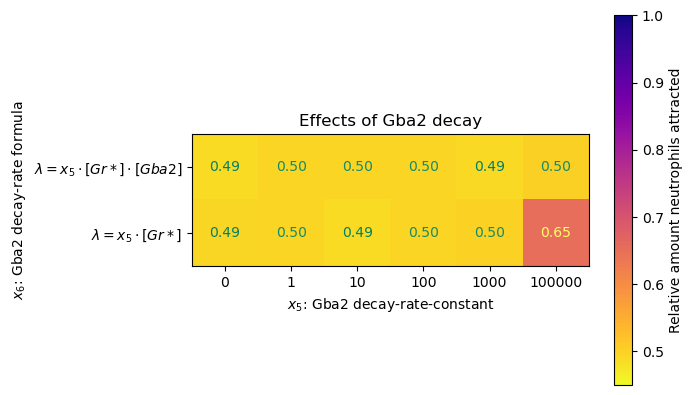

In [46]:
fig, ax = plt.subplots()
ax, image, colorbar = make_heatmap(table, col_labels=GBA2_DECAY_RATE_CONSTANTS,
    row_labels=[
        r"$\lambda = x_5 \cdot [Gr*] \cdot [Gba2]$",
        r"$\lambda = x_5 \cdot [Gr*]$"],
    cmap=CMAP,
    imshow_kwargs = {
        "vmin":VMIN,
        "vmax":VMAX},
    ax=ax
)

ax.set_title("Effects of Gba2 decay")
ax.set_ylabel("$x_6$: Gba2 decay-rate formula")
ax.set_xlabel("$x_5$: Gba2 decay-rate-constant")
colorbar.ax.set_ylabel("Relative amount neutrophils attracted");

fig.savefig(os.path.join(MAIN_SAVE_DIR, "heatmap_gba2_decay.pdf"))

## Graph of the run with the strongest decay
That is, with $x_5 = 100000$ and $x_6 = \texttt{True}$.

You can see that a quite some GbPdn is initially converted to Pdn, rather quickly,
before we run out of Gba2.
The total amount of Pdn/Gr* is probably less
than without negative feedback to Gba2,
but the negative feedback only occurs when Gr*
is high enough to suppress the inflammation
anyway.
Of course, if the effect of Gr* would be weaker,
or if some threshold concentration is needed
for inhibiting the inflammation (but not to inhibit Gba2), 
then the effects may be bigger.

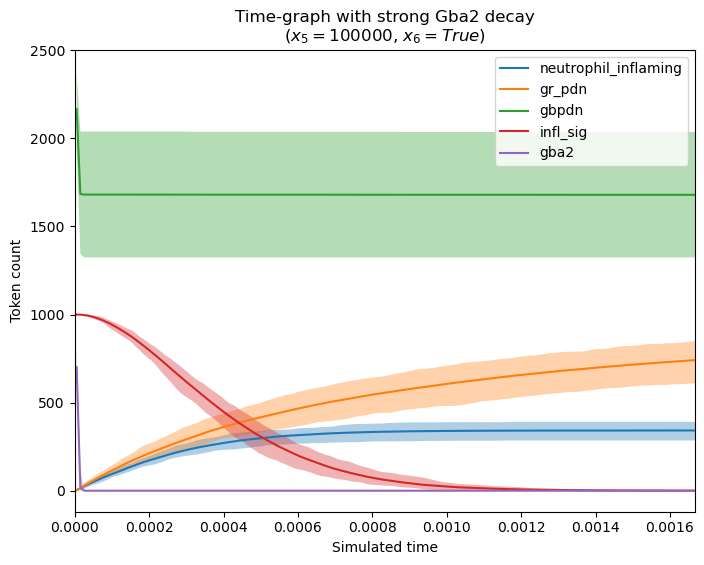

In [50]:
exp_dir = os.path.join(GBA2_DECAY_SAVE_DIR, "x1_3000__x2_100__x3_0__x4_0", 
                       "exp_10", "logs.json")
logs = load_log(exp_dir)
num_timeboxes = get_num_timeboxes_for_fixed_duration(logs, 
                                        DESIRED_TIMEBOX_DURATION)

fig, ax = plt.subplots(figsize=(8, 6))
plot_results(logs, x_var="time", y_vars = ("neutrophil_inflaming", "gr_pdn", 
    "gbpdn", "infl_sig", "gba2"),
    num_timeboxes=num_timeboxes, ax=ax)

ax.set(
    ylabel=PLOT_Y_LABEL,
    xlabel=PLOT_X_LABEL,
    xlim=(PLOT_X_LIMS[0], PLOT_X_LIMS[1]/3),
    title="Time-graph with strong Gba2 decay\n($x_5=100000$, $x_6=True$)"
)

fig.savefig(os.path.join(MAIN_SAVE_DIR, "graph_gba2_decay.pdf"))